# Hazard Risk Index

Through the following process, we propose a methodology to calculate the hazard index for a specific location.

1. Selection of hazard types that could impact the installation and long-term operation of EVCS (Electric Vehicle Charging Stations).
2. Scaling the risk levels of each disaster type using a uniform standard.
3. Generating a hazard risk map.
4. Calculating the hazard index for a specific point based on the risk radius of each disaster type.

__The followings covers process 1 to 3, and the results have been visualized.__

Number of rows after merge: 1969
       GEOID10       SF               CF  DF_PFS  AF_PFS  HDF_PFS  DSF_PFS  \
0  13135050709  Georgia  Gwinnett County    0.68    0.54     0.27     0.59   
1  13135050314  Georgia  Gwinnett County    0.43    0.16     0.10     0.89   
2  13135050315  Georgia  Gwinnett County    0.33    0.27     0.12     0.89   
3  13135050415  Georgia  Gwinnett County    0.75    0.14     0.60     0.72   
4  13135050425  Georgia  Gwinnett County    0.43    0.06     0.35     0.74   

   EBF_PFS  EALR_PFS  EBLR_PFS  ...  BLR_90_LI  BLR_NHR  Flood  Fld_90_LI  \
0     0.61      0.61      0.51  ...      False     51.0   59.0      False   
1     0.59      0.36      0.56  ...      False     56.0   45.0      False   
2     0.44      0.44      0.55  ...      False     55.0   25.0      False   
3     0.72      0.26      0.51  ...      False     51.0   42.0      False   
4     0.32      0.51      0.53  ...      False     53.0   37.0      False   

   Flood_90  BLR_abs  Fld_abs  BLR_

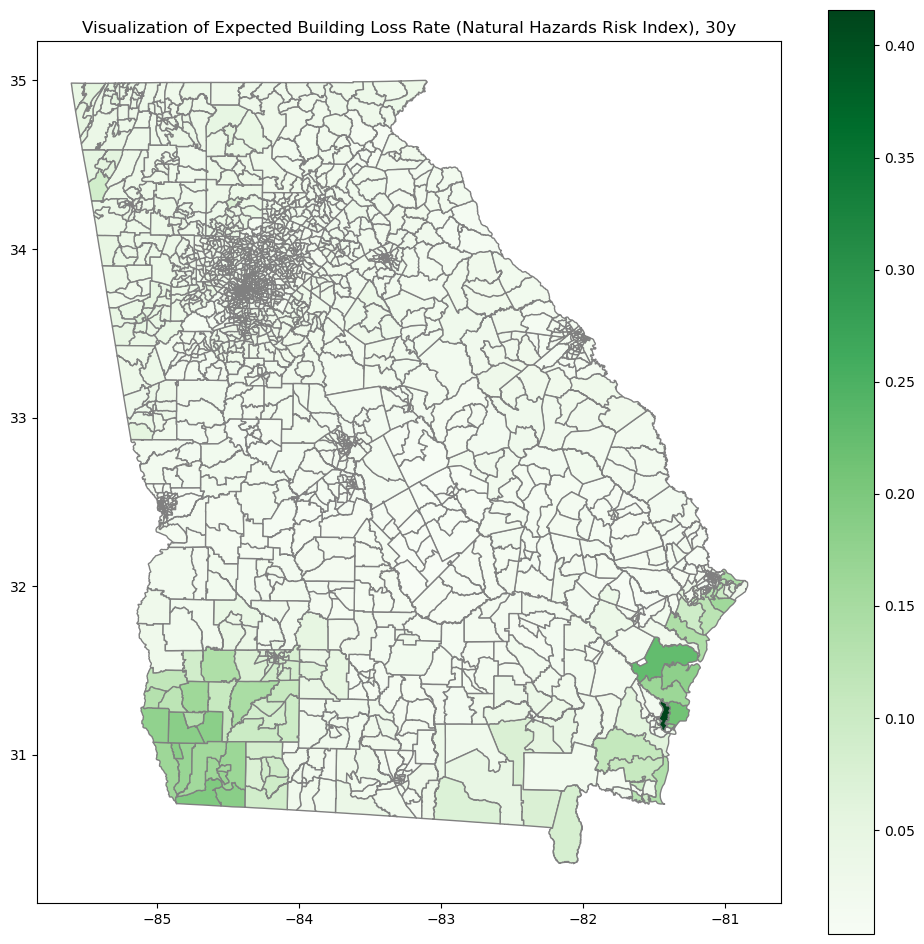

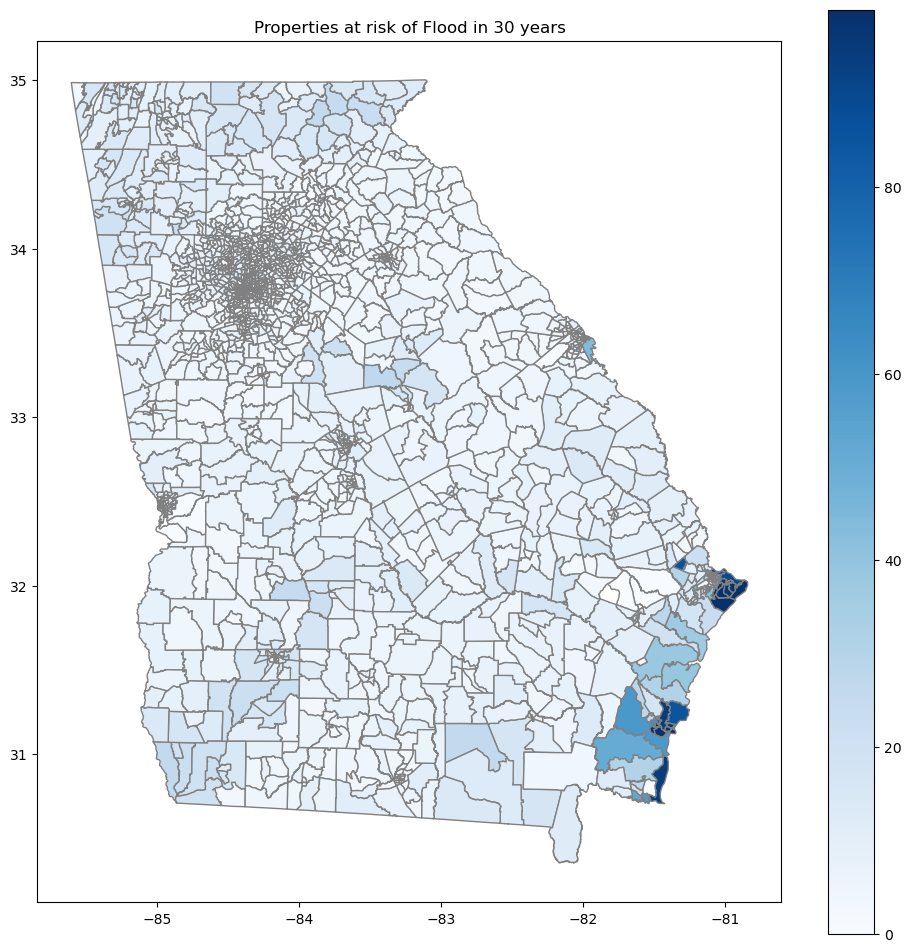

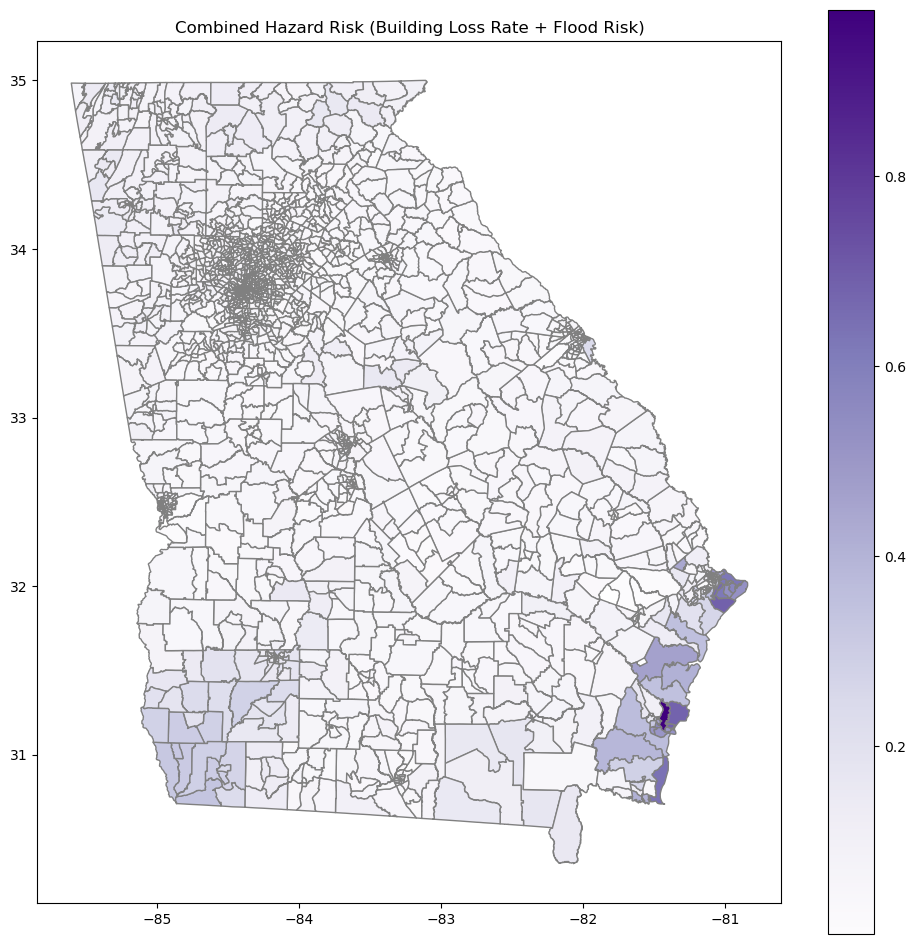

In [3]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Step 1: Load Shapefile and CSV data
# Purpose: Merging geographic data (shapefile) with attribute data (CSV) containing hazard information for each census tract in Georgia.

# File paths for the Shapefile and CSV
shapefile_path = None # (e.g., /path/to/usa.shp) Georgia cut out from across the U.S.
csv_file_path = None # (e.g., /path/to/justice40_data/1.0-communities_Georgia.csv)

# Load shapefile
gdf = gpd.read_file(shapefile_path)

# Load CSV data
df = pd.read_csv(csv_file_path)

# Convert 'Census tract 2010 ID' to string for correct merging
df['Census tract 2010 ID'] = df['Census tract 2010 ID'].astype(str)

# Step 2: Rename CSV columns for easier reference
# Purpose: Shorten the column names to make the code more readable.
df = df.rename(columns={
    'Greater than or equal to the 90th percentile for expected building loss rate and is low income?': 'BLR_90_LI',
    'Expected building loss rate (Natural Hazards Risk Index) (percentile)': 'BLR_NHR',
    'Share of properties at risk of flood in 30 years (percentile)': 'Flood',
    'Greater than or equal to the 90th percentile for share of properties at risk of flood in 30 years and is low income?': 'Fld_90_LI',
    'Greater than or equal to the 90th percentile for share of properties at risk of flood in 30 years': 'Flood_90',
})

# Step 3: Create BLR_abs and Fld_abs columns
# Purpose: Calculate and add absolute hazard risk columns for building loss rate and flood risk.

df = df.rename(columns={
    'Expected building loss rate (Natural Hazards Risk Index)': 'BLR_abs',
    'Share of properties at risk of flood in 30 years': 'Fld_abs'
})

# Step 4: Merge Shapefile and CSV data
# Purpose: Merge the data based on 'GEOID10' (in the shapefile) and 'Census tract 2010 ID' (in the CSV).
merged_gdf = gdf.merge(df[['Census tract 2010 ID', 'BLR_90_LI', 'BLR_NHR', 'Flood', 'Fld_90_LI', 'Flood_90', 'BLR_abs', 'Fld_abs']], 
                       left_on='GEOID10', right_on='Census tract 2010 ID')

# Drop the 'Census tract 2010 ID' column from the merged GeoDataFrame
merged_gdf = merged_gdf.drop(columns=['Census tract 2010 ID'])

# Step 5: Scaling 'BLR_abs' and 'Fld_abs' to a range of 0 to 1
scaler = MinMaxScaler()

# Fit the scaler and transform the 'BLR_abs' and 'Fld_abs' columns
merged_gdf[['BLR_scaled', 'Fld_scaled']] = scaler.fit_transform(merged_gdf[['BLR_abs', 'Fld_abs']])

# Step 6: Combine 'BLR_scaled' and 'Fld_scaled' with equal weighting
# Purpose: Create a new column that combines both scaled columns with a weight of 1:1
merged_gdf['Combined_Hazard'] = (merged_gdf['BLR_scaled'] + merged_gdf['Fld_scaled']) / 2

# Step 7: Save merged data to a new shapefile
output_shapefile_path_abs = None # (e.g., /path/to/Georgia_hazard_merged(abs).shp)
merged_gdf.to_file(output_shapefile_path_abs)

# Step 8: Check the number of rows in the merged data
# Purpose: Verify that the merging process worked as expected.
print(f"Number of rows after merge: {len(merged_gdf)}")
print(merged_gdf.head())

# Step 9: Visualization
# Purpose: Visualize the combined hazard risk using maps.

# Visualize expected building loss rate
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
merged_gdf.plot(column='BLR_abs', cmap='Greens', legend=True, edgecolor='grey', ax=ax)
plt.title('Visualization of Expected Building Loss Rate (Natural Hazards Risk Index), 30y')
plt.show()

# Visualize flood risk
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
merged_gdf.plot(column='Fld_abs', cmap='Blues', legend=True, edgecolor='grey', ax=ax)
plt.title('Properties at risk of Flood in 30 years')
plt.show()

# Visualize combined hazard risk (BLR + Flood)
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
merged_gdf.plot(column='Combined_Hazard', cmap='Purples', legend=True, edgecolor='grey', ax=ax)
plt.title('Combined Hazard Risk (Building Loss Rate + Flood Risk)')
plt.show()


# Hazard Index on POI (or any points in Georgia)

* The process of performing '4. Calculating the hazard index for a specific point based on the risk radius of each disaster type.'
* The hazard risk (relative risk) of the EVCS candidate sites is calculated and added as an attribute to each point.

/tmp/ipykernel_1848263/174339262.py:79: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  poi.to_file(output_shapefile_path)
/opt/anaconda3/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'hazard_risk' to 'hazard_ris'
  ogr_write(
/opt/anaconda3/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'hazard_risk_scaled' to 'hazard_r_1'
  ogr_write(


POIs with hazard risk scores saved to: /home/ojin/working_space/SIG/1차 결과(0916)/비정전_merge_hazard.shp


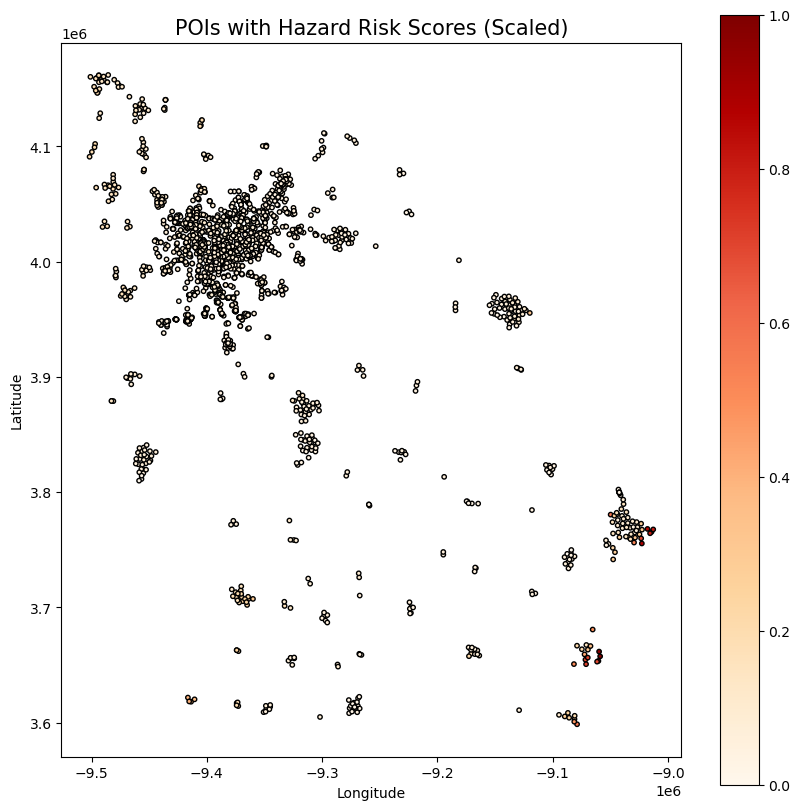

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.preprocessing import MinMaxScaler
from joblib import Parallel, delayed

# Step 1: Load census tract and points of interest (POI) data
# Purpose: Use census tract data and points of interest to calculate hazard risk scores based on building loss and flood risk.
census_tract = gpd.read_file(None) # /path/to/filtered_usa.shp (cut Georgia from usa.shp)
poi = gpd.read_file(None) # '/path/to/calculate/hazard/risk/poi.shp

# Step 2: Load the shapefile containing the processed hazard data (building loss and flood risk for Georgia)
shapefile_path = None # "/path/to/Georgia_hazard_merged(abs).shp"
gdf = gpd.read_file(shapefile_path)

# Step 3: Initialize a scaler for risk score normalization (0-1 scale)
scaler = MinMaxScaler()

# Step 4: Average damage data for floods (adjustable based on real data)
flood_avg_damage = 3.8  # Example value from USA disaster statistics

# Step 5: Calculate predicted hazard risk by scaling building loss rate and flood risk
# Formula: flood risk = flood occurrence * average flood damage (normalized)
gdf['BLR_scaled'] = scaler.fit_transform(gdf[['BLR_abs']])
gdf['Fld_scaled'] = scaler.fit_transform(gdf[['Fld_abs']] * flood_avg_damage)

# Step 6: Replace NaN values with 0 to ensure no missing data
gdf[['BLR_scaled', 'Fld_scaled']] = gdf[['BLR_scaled', 'Fld_scaled']].fillna(0)

# Step 7: Calculate the total hazard score as the average of scaled building loss rate and flood risk
gdf['total_cost'] = (gdf['BLR_scaled'] + gdf['Fld_scaled']) / 2

# Step 8: Reproject all datasets to EPSG:3857 coordinate system (Web Mercator) for consistency
census_tract = census_tract.to_crs(epsg=3857)
poi = poi.to_crs(epsg=3857)
gdf = gdf.to_crs(epsg=3857)

# Step 9: Define buffer radii around the POIs (1km and 3km) for hazard calculation
radius_A = 1000  # 1km radius for nearby risks
radius_B = 3000  # 3km radius for wider flood impacts

# Step 10: Create buffers around each POI using the defined radii
poi_buffers_A = poi.buffer(radius_A)
poi_buffers_B = poi.buffer(radius_B)

# Step 11: Define a function to calculate weighted risk scores based on intersecting census tracts
def calculate_risk_based_score_polygon(poi_buffer, census_tracts, risk_scores_scaled):
    # Find intersecting census tracts with the POI buffer
    intersecting_tracts = census_tracts[census_tracts.intersects(poi_buffer)]
    
    if not intersecting_tracts.empty:
        # Calculate area-weighted average risk score for the intersecting tracts
        weights = intersecting_tracts.intersection(poi_buffer).area / intersecting_tracts.area
        weighted_risk = np.average(risk_scores_scaled[intersecting_tracts.index], weights=weights)
        return weighted_risk
    else:
        return 0  # Return 0 if no intersecting tracts are found

# Step 12: Parallel computation of risk scores for POIs based on both building loss and flood risk
risk_based_scores_A_scaled = Parallel(n_jobs=5)(delayed(calculate_risk_based_score_polygon)(
    poi_buffers_A[i], gdf, gdf['BLR_scaled'].to_numpy()) for i in range(len(poi)))

risk_based_scores_B_scaled = Parallel(n_jobs=5)(delayed(calculate_risk_based_score_polygon)(
    poi_buffers_B[i], gdf, gdf['Fld_scaled'].to_numpy()) for i in range(len(poi)))

# Step 13: Calculate the final hazard score for each POI as the average of building loss and flood risk
aggregate_scores_scaled = (np.array(risk_based_scores_A_scaled) + np.array(risk_based_scores_B_scaled)) / 2

# Step 14: Add the calculated hazard risk score to the POI dataset
poi['hazard_risk'] = aggregate_scores_scaled

# Step 15: Rescale the hazard risk score to a 0-1 scale using MinMaxScaler
poi['hazard_risk_scaled'] = scaler.fit_transform(poi[['hazard_risk']])

# Step 16: Save the updated POI shapefile with the hazard risk scores
output_shapefile_path = None # (e.g., /path/to/result_with_hazard_index.shp)
poi.to_file(output_shapefile_path)

# Print completion message
print(f"POIs with hazard risk scores saved to: {output_shapefile_path}")

# Step 17: Visualization of POI risk scores
# Purpose: Plot POIs with color intensity based on their hazard risk score.
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Step 18: Plot POIs with color intensity representing the hazard_risk_scaled score
poi.plot(column='hazard_risk_scaled', cmap='OrRd', markersize=10, legend=True, ax=ax, edgecolor='black')

# Step 19: Add title and labels
plt.title("POIs with Hazard Risk Scores (Scaled)", fontsize=15)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Step 20: Show the plot
plt.show()
